![img](Images/cover.jpg)

# WebFlix Recomendation System
By Victor Chen, Brian Matsiko, Erin Vu
_________________________________________________________________________________________________

## Overview

Our project is a recommendation engine that uses collaborative filtering and content based filtering in order to recommend movies to users based off of movie ratings from the MovieLens dataset. 

## Business Problem

Our stakeholder is a new movie streaming service trying to get into the media services business. In order to serve our customer base, we need to understand what they enjoy to provide them content they would like to see. Because our service is new, we will encounter the cold start problem due to new users without history joining our platform. Our goal of this project is to build a model that provides the top 5 movie recommendations to a user. 
_________________________________________________________________________

## Data Understanding

The data used in this set is from the [MovieLens](https://grouplens.org/datasets/movielens/latest/) dataset. In this project, we will be working with the smaller dataset of 100,000 ratings of 9,000 movies from 600 users. We will use the ratings from the users to make recommendations for movies based off of other users ratings. The dataset was last updated on 9/2018. We are working towards a model that works on the smaller data set and hope to apply it to the larger dataset or another subset of the larget dataset with the same success.
______________________________________

## Data Preparation

In [1]:
# Import standard packages
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pylab import rcParams
from PIL import Image
%matplotlib inline

In [2]:
# Load movies
movies = pd.read_csv("./small_data/ml-latest-small/movies.csv")
movies = movies.replace({np.nan: None}) # replace NaN with None
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
# Load movies
ratings = pd.read_csv("./small_data/ml-latest-small/ratings.csv")
ratings = ratings.replace({np.nan: None}) # replace NaN with None
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
df = pd.merge(movies, ratings)

In [5]:
movies.count()

movieId    9742
title      9742
genres     9742
dtype: int64

In [6]:
ratings.count()

userId       100836
movieId      100836
rating       100836
timestamp    100836
dtype: int64

In [7]:
Average_ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
Average_ratings

,rating
title,
'71 (2014),4.000000
'Hellboy': The Seeds of Creation (2004),4.000000
'Round Midnight (1986),3.500000
'Salem's Lot (2004),5.000000
'Til There Was You (1997),4.000000
...,...
eXistenZ (1999),3.863636
xXx (2002),2.770833
xXx: State of the Union (2005),2.000000


In [8]:
Average_ratings['Total Ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())
Average_ratings.head(10)

,rating,Total Ratings
title,,
'71 (2014),4.000000,1
'Hellboy': The Seeds of Creation (2004),4.000000,1
'Round Midnight (1986),3.500000,2
'Salem's Lot (2004),5.000000,1
'Til There Was You (1997),4.000000,2
'Tis the Season for Love (2015),1.500000,1
"'burbs, The (1989)",3.176471,17
'night Mother (1986),3.000000,1
(500) Days of Summer (2009),3.666667,42


In [9]:
import seaborn as sns


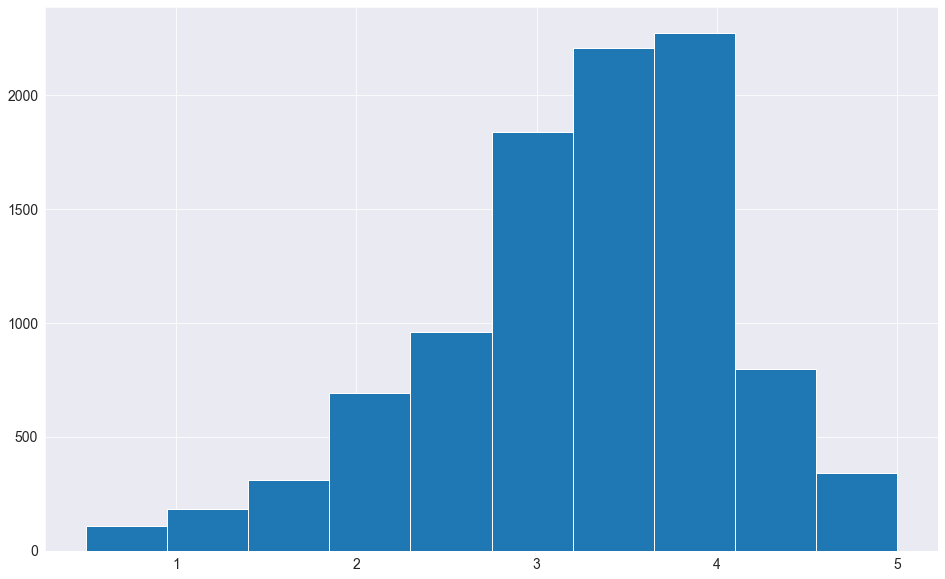

In [10]:
sns.set_style('darkgrid')
Average_ratings['rating'].hist(figsize=(16,10), xlabelsize=14, ylabelsize=14);

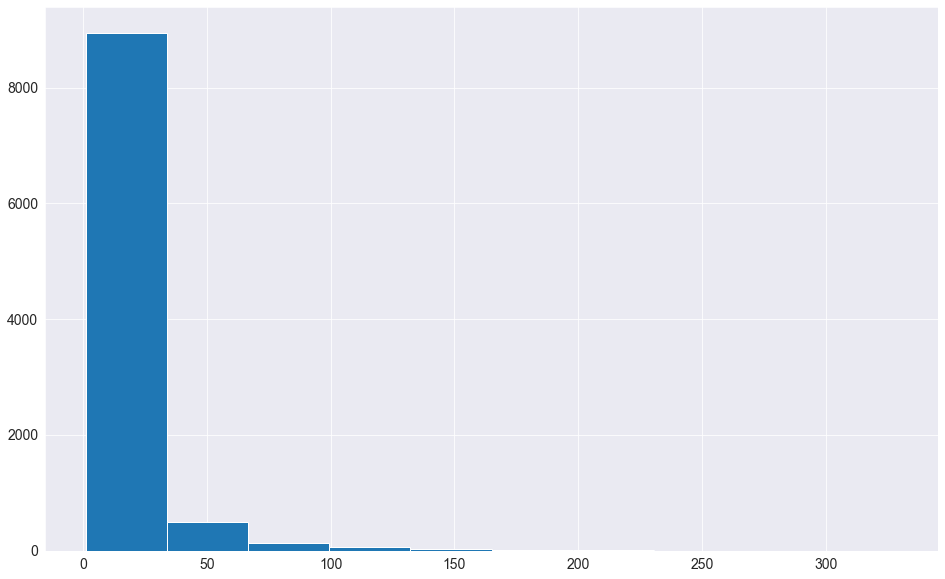

In [11]:
Average_ratings['Total Ratings'].hist(figsize=(16,10), xlabelsize=14, ylabelsize=14);

In [12]:
print("If there is missing data in each table?")
print('movie: {}'.format(movies.count() == movies.dropna().count()))
print('ratings: {}'.format(ratings.count() == ratings.dropna().count()))

If there is missing data in each table?
movie: movieId    True
title      True
genres     True
dtype: bool
ratings: userId       True
movieId      True
rating       True
timestamp    True
dtype: bool


In [13]:
#Using regular expressions to find a year stored between parentheses
#We specify the parantheses so we don't conflict with movies that have years in their titles
movies['year'] = movies.title.str.extract('(\(\d\d\d\d\))',expand=False)
#Removing the parentheses
movies['year'] = movies.year.str.extract('(\d\d\d\d)',expand=False)
#Removing the years from the 'title' column
movies['title'] = movies.title.str.replace('(\(\d\d\d\d\))', '')
#Applying the strip function to get rid of any ending whitespace characters that may have appeared
movies['title'] = movies['title'].apply(lambda x: x.strip())
movies.head(10)

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995
5,6,Heat,Action|Crime|Thriller,1995
6,7,Sabrina,Comedy|Romance,1995
7,8,Tom and Huck,Adventure|Children,1995
8,9,Sudden Death,Action,1995
9,10,GoldenEye,Action|Adventure|Thriller,1995


<BarContainer object of 19 artists>

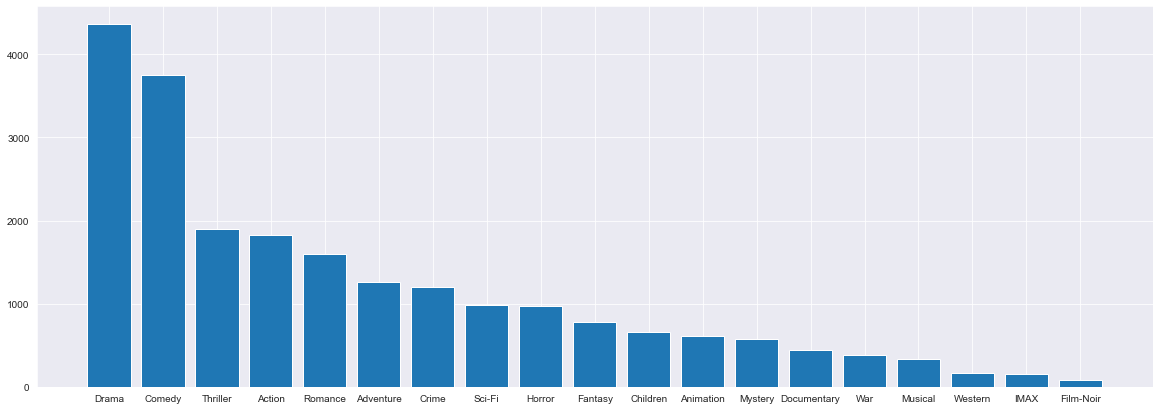

In [14]:
# distribution of genre counts
plt.figure(figsize=(20,7))
generlist = movies['genres'].apply(lambda generlist_movie : str(generlist_movie).split("|"))
geners_count = {}

for generlist_movie in generlist:
    for gener in generlist_movie:
        if(geners_count.get(gener,False)):
            geners_count[gener]=geners_count[gener]+1
        else:
            geners_count[gener] = 1       
geners_count.pop("(no genres listed)")
geners_count = sorted(geners_count.items(), key=lambda x: x[1], reverse=True)
geners_count = dict(geners_count)
plt.bar(geners_count.keys(),geners_count.values())

Total of 106 uinque years from 1902 to 2018


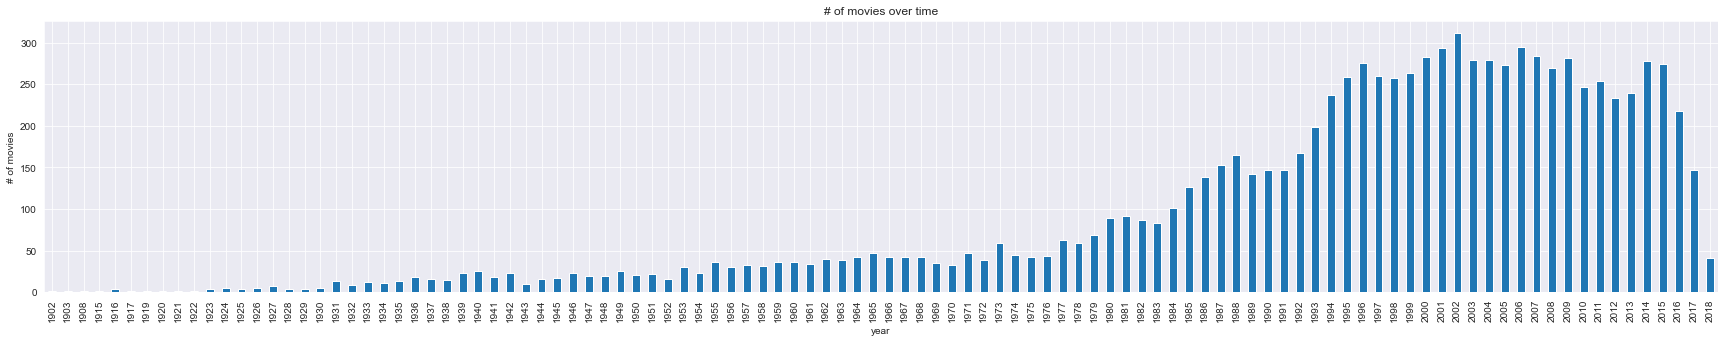

In [15]:
# Years
years = movies[movies.year.notnull()].year # get rows where year is not None
print (f"Total of {len(set(years))} uinque years from {min(years)} to {max(years)}")
pd.Series(years).value_counts().sort_index().plot(kind='bar', figsize=(30, 5))
plt.title("# of movies over time")
plt.ylabel("# of movies")
plt.xlabel("year")
plt.show()

In [16]:
#Every genre is separated by a | so we simply have to call the split function on |
movies['genres'] = movies.genres.str.split('|')
movies.head(10)

,movieId,title,genres,year
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995
4,5,Father of the Bride Part II,[Comedy],1995
5,6,Heat,"[Action, Crime, Thriller]",1995
6,7,Sabrina,"[Comedy, Romance]",1995
7,8,Tom and Huck,"[Adventure, Children]",1995
8,9,Sudden Death,[Action],1995
9,10,GoldenEye,"[Action, Adventure, Thriller]",1995


In [17]:
#Copying the movie dataframe into a new one since we won't need to use the genre information in our first case.
moviesWithGenres = movies.copy()

#For every row in the dataframe, iterate through the list of genres and place a 1 into the corresponding column
for index, row in movies.iterrows():
    for genre in row['genres']:
        moviesWithGenres.at[index, genre] = 1
#Filling in the NaN values with 0 to show that a movie doesn't have that column's genre
moviesWithGenres = moviesWithGenres.fillna(0)
moviesWithGenres.head(10)

,movieId,title,genres,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men,"[Comedy, Romance]",1995,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Father of the Bride Part II,[Comedy],1995,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,6,Heat,"[Action, Crime, Thriller]",1995,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,7,Sabrina,"[Comedy, Romance]",1995,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,8,Tom and Huck,"[Adventure, Children]",1995,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,9,Sudden Death,[Action],1995,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,10,GoldenEye,"[Action, Adventure, Thriller]",1995,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
#Drop removes a specified row or column from a dataframe
ratings = ratings.drop('timestamp', 1)
ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [19]:
#Merge is a function that combines all the rows of the dataset with the specified dataframe.
data = ratings.merge(movies,on='movieId', how='left')
data.head(10)

,userId,movieId,rating,title,genres,year
0,1,1,4.0,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,1,3,4.0,Grumpier Old Men,"[Comedy, Romance]",1995
2,1,6,4.0,Heat,"[Action, Crime, Thriller]",1995
3,1,47,5.0,Seven (a.k.a. Se7en),"[Mystery, Thriller]",1995
4,1,50,5.0,"Usual Suspects, The","[Crime, Mystery, Thriller]",1995
5,1,70,3.0,From Dusk Till Dawn,"[Action, Comedy, Horror, Thriller]",1996
6,1,101,5.0,Bottle Rocket,"[Adventure, Comedy, Crime, Romance]",1996
7,1,110,4.0,Braveheart,"[Action, Drama, War]",1995
8,1,151,5.0,Rob Roy,"[Action, Drama, Romance, War]",1995
9,1,157,5.0,Canadian Bacon,"[Comedy, War]",1995


## Data Modeling

Below, we will begin our modeling process. We begin with collaborative filtering to build our recommendation engine. Collaborative filtering uses the ratings from the user and measures it up against the other users' ratings.

### Collaborative Filtering Based Recommendation System

In [20]:
from surprise import NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate, GridSearchCV

reader = Reader(rating_scale=(1, 5))

data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [21]:
from surprise import BaselineOnly, SVD
from surprise import KNNBasic, KNNWithMeans, KNNBaseline
from surprise import NMF
from surprise import CoClustering
from surprise import SlopeOne
from surprise.model_selection import cross_validate

#### Baseline Model

In [22]:
baseline = BaselineOnly()
baseline_cv = cross_validate(baseline, data, measures=['RMSE'], cv=5, verbose=False)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


In [23]:
baseline_rmse = np.mean(baseline_cv['test_rmse'])
print(f'Baseline RMSE {baseline_rmse}')

Baseline RMSE 0.872792183227455


#### Other Models
Below we will cross validate other models to find our best RMSE scoring model and build upon that model.

In [24]:
svd = SVD()
knnbasic = KNNBasic()
nmf = NMF()
coclustering = CoClustering()
slopeone = SlopeOne()
knnwithmeans = KNNWithMeans()

# 5-fold cross-validation
baseline_dict = cross_validate(baseline, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)
svd_dict = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)
knnbasic_dict = cross_validate(knnbasic, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)
nmf_dict = cross_validate(nmf, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)
coclustering_dict = cross_validate(coclustering, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)
slopeone_dict = cross_validate(slopeone, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)
knnwithmeans_dict = cross_validate(knnwithmeans, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


In [25]:
baseline_rmse = np.mean(baseline_dict['test_rmse'])
print(f'Baseline RMSE {baseline_rmse}')
svd_rmse = np.mean(svd_dict['test_rmse'])
print(f'SVD RMSE {svd_rmse}')
knnbasic_rmse = np.mean(knnbasic_dict['test_rmse'])
print(f'KNNBasic RMSE {knnbasic_rmse}')
nmf_rmse = np.mean(nmf_dict['test_rmse'])
print(f'NMF RMSE {nmf_rmse}')
coclustering_rmse = np.mean(coclustering_dict['test_rmse'])
print(f'CoClustering RMSE {coclustering_rmse}')
slopeone_rmse = np.mean(slopeone_dict['test_rmse'])
print(f'SlopeOne RMSE {slopeone_rmse}')
knnwithmeans_rmse = np.mean(knnwithmeans_dict['test_rmse'])
print(f'KNNwithMeansRMSE {knnwithmeans_rmse}')

Baseline RMSE 0.8724134704162214
SVD RMSE 0.8737471873203567
KNNBasic RMSE 0.947546566504955
NMF RMSE 0.9221112800320148
CoClustering RMSE 0.9445778027021644
SlopeOne RMSE 0.9000344154899425
KNNwithMeansRMSE 0.8969494493091844


<ipython-input-26-a265285609c6>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(algos, fontsize=14)
<ipython-input-26-a265285609c6>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0', '0.88', '0.90', '0.92', '0.94'], fontsize=14);


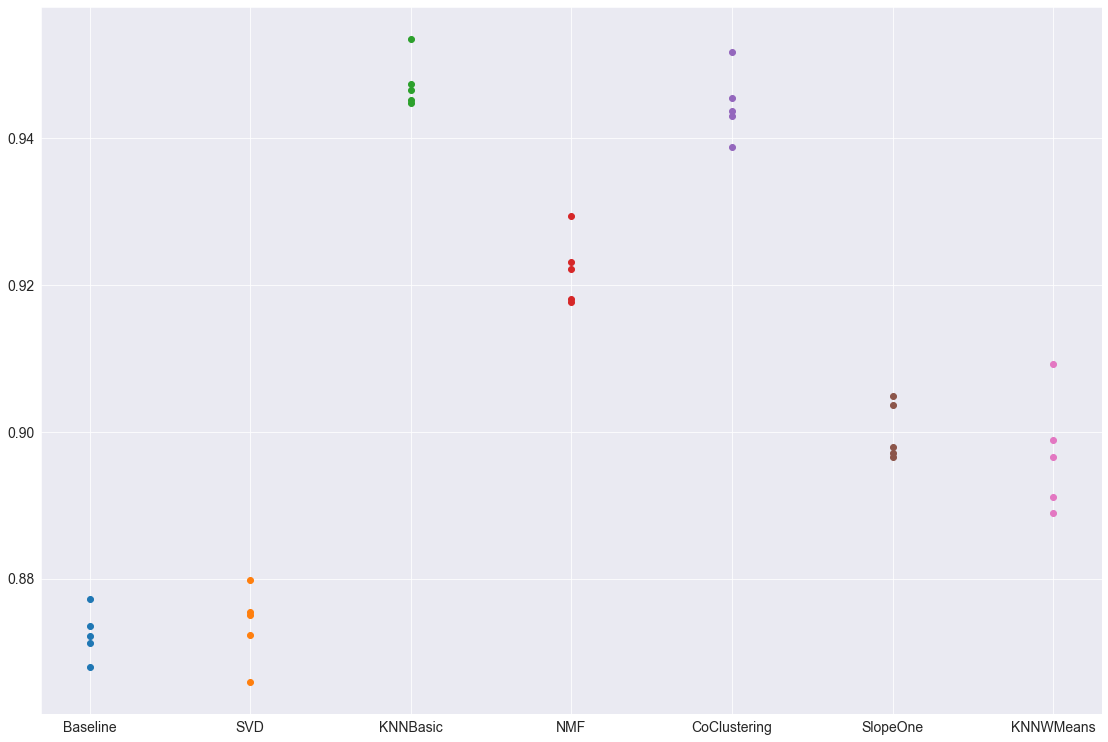

In [26]:
fig, ax = plt.subplots(figsize=(19,13))
algos = ['Baseline', 'SVD', 'KNNBasic', 'NMF', 'CoClustering', 'SlopeOne', 'KNNWMeans']
x_pos = np.arange(float(len(algos)))

Y = [baseline_dict['test_rmse'], svd_dict['test_rmse'], knnbasic_dict['test_rmse'], nmf_dict['test_rmse'], coclustering_dict['test_rmse'], slopeone_dict['test_rmse'], knnwithmeans_dict['test_rmse']]
for y in range(len(Y)):
    plt.scatter([algos[y], algos[y], algos[y], algos[y], algos[y]], Y[y], marker='o')
#ax.set_title('RMSE', fontsize=16);
ax.set_xticklabels(algos, fontsize=14)
ax.set_yticklabels(['0', '0.88', '0.90', '0.92', '0.94'], fontsize=14);

Above we can observe that SVD has the lowest rmse and we will continue with gridsearch to find the best parameters for that model.

#### SVD Grid Search

In [27]:
params = {'n_factors': [10, 20, 75],
         'reg_all': [0.01, 0.02, 0.05],
         'lr_all' : [0.0025, 0.005, 0.01, 0.1]}
g_s_svd = GridSearchCV(SVD,param_grid=params,n_jobs=-1,refit=True)

In [28]:
g_s_svd.fit(data)

In [29]:
# Optimal parameters for SVD after GridSearch
print(g_s_svd.best_score)
print(g_s_svd.best_params)

{'rmse': 0.8602944074007194, 'mae': 0.6596203492564726}
{'rmse': {'n_factors': 75, 'reg_all': 0.05, 'lr_all': 0.01}, 'mae': {'n_factors': 75, 'reg_all': 0.05, 'lr_all': 0.01}}


Above we can see our best paramaters from our grid search and will implement to get predictions.

In [30]:
trainset = data.build_full_trainset()
svd_best = SVD(n_factors= 75, reg_all=0.05, lr_all=.01)
svd_best.fit(trainset)

In [31]:
svd_best.predict(2, 4)

Prediction(uid=2, iid=4, r_ui=None, est=2.8584514455250507, details={'was_impossible': False})

In [32]:
from collections import defaultdict

def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [33]:
# Predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = svd_best.test(testset)

top_n = get_top_n(predictions, n=10)

# Recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

1 [318, 720, 1272, 32, 904, 930, 1199, 1203, 2019, 2324]
2 [177593, 3451, 1203, 3266, 858, 1212, 1041, 1280, 4973, 3435]
3 [1200, 1625, 497, 120138, 4144, 1261, 1214, 1215, 106782, 1956]
4 [1212, 720, 3089, 3435, 6331, 924, 926, 1207, 2908, 1262]
5 [7153, 1104, 177593, 4993, 6104, 3508, 720, 5952, 1178, 1204]
6 [3200, 899, 7008, 1270, 1172, 1237, 3451, 57504, 1041, 1104]
7 [56782, 1197, 112421, 1104, 3030, 904, 1198, 3451, 1203, 2791]
8 [1213, 177593, 858, 608, 750, 1221, 1089, 1208, 1178, 1196]
9 [1104, 1237, 318, 3451, 3468, 2732, 1218, 858, 1035, 5013]
10 [457, 76093, 720, 908, 919, 26810, 951, 2202, 899, 1104]
11 [3451, 1200, 904, 3022, 898, 1196, 260, 4973, 1198, 527]
12 [50, 110, 260, 527, 593, 608, 1196, 1198, 1208, 1210]
13 [296, 858, 1204, 5747, 2959, 318, 2324, 1221, 1178, 246]
14 [1104, 3266, 7156, 27156, 1217, 26810, 5690, 106642, 2324, 3201]
15 [1172, 912, 177593, 930, 1225, 951, 2360, 7008, 1104, 27611]
16 [3451, 1178, 1104, 71899, 2360, 106642, 1237, 1217, 951, 3201]
17 

518 [3451, 1237, 1172, 78499, 1704, 57669, 27156, 7153, 2571, 750]
519 [177593, 1248, 898, 750, 1104, 1178, 3451, 930, 3266, 2324]
520 [177593, 899, 71899, 1237, 1178, 3451, 2360, 1148, 1104, 3022]
521 [1104, 177593, 930, 4993, 1217, 5952, 3266, 71899, 3451, 1262]
522 [293, 3451, 109487, 168252, 3201, 174053, 3429, 6, 7121, 115569]
523 [1213, 2329, 80906, 720, 1272, 898, 930, 1283, 1719, 2203]
524 [27156, 951, 1204, 1223, 1213, 1212, 2571, 741, 1265, 1284]
525 [3451, 177593, 3266, 1217, 1237, 1104, 71899, 3022, 158966, 898]
526 [1104, 1217, 3451, 177593, 3266, 56782, 1041, 3468, 912, 1245]
527 [3451, 98491, 2583, 6440, 86345, 56782, 44195, 3200, 1237, 27156]
528 [3275, 928, 57504, 92535, 6350, 1204, 1280, 52885, 2324, 2959]
529 [1198, 318, 3200, 1104, 3836, 1204, 56782, 27156, 4993, 1036]
530 [3451, 318, 177593, 750, 1104, 1178, 1204, 912, 1203, 951]
531 [1196, 318, 898, 1041, 2571, 3451, 3266, 527, 858, 296]
532 [1104, 177593, 356, 1217, 112290, 1041, 1089, 260, 106642, 4973]
533 [345

### Content-Based Recommendation System

Below we will tackle the cold start problem by creating a content-based recommendation system.

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [35]:
df_movies = pd.read_csv("./small_data/ml-latest-small/movies.csv")
df_movies = df_movies.replace({np.nan: None})
df_ratings = pd.read_csv("./small_data/ml-latest-small/ratings.csv")
df_ratings = df_ratings.replace({np.nan: None})

In [36]:
# Define a TF-IDF Vectorizer Object.
tfidf_movies_genres = TfidfVectorizer(token_pattern = '[a-zA-Z0-9\-]+')

#Replace NaN with an empty string
df_movies['genres'] = df_movies['genres'].replace(to_replace="(no genres listed)", value="")

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_movies_genres_matrix = tfidf_movies_genres.fit_transform(df_movies['genres'])
print(tfidf_movies_genres.get_feature_names())
# Compute the cosine similarity matrix
print(tfidf_movies_genres_matrix.shape)
print(tfidf_movies_genres_matrix.dtype)
cosine_sim_movies = linear_kernel(tfidf_movies_genres_matrix, tfidf_movies_genres_matrix)
print(cosine_sim_movies)

['action', 'adventure', 'animation', 'children', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'film-noir', 'horror', 'imax', 'musical', 'mystery', 'romance', 'sci-fi', 'thriller', 'war', 'western']
(9742, 19)
float64
[[1.         0.81357774 0.15276924 ... 0.         0.4210373  0.26758648]
 [0.81357774 1.         0.         ... 0.         0.         0.        ]
 [0.15276924 0.         1.         ... 0.         0.         0.57091541]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.4210373  0.         0.         ... 0.         1.         0.        ]
 [0.26758648 0.         0.57091541 ... 0.         0.         1.        ]]


In [37]:
def get_recommendations_based_on_genres(movie_title, cosine_sim_movies=cosine_sim_movies):
    """
    Calculates top 2 movies to recommend based on given movie titles genres. 
    :param movie_title: title of movie to be taken for base of recommendation
    :param cosine_sim_movies: cosine similarity between movies 
    :return: Titles of movies recommended to user
    """
    # Get the index of the movie that matches the title
    idx_movie = df_movies.loc[df_movies['title'].isin([movie_title])]
    idx_movie = idx_movie.index
    
    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores_movies = list(enumerate(cosine_sim_movies[idx_movie][0]))
    
    # Sort the movies based on the similarity scores
    sim_scores_movies = sorted(sim_scores_movies, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores_movies = sim_scores_movies[1:6]
    
    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores_movies]
    
    # Return the top 2 most similar movies
    return df_movies['title'].iloc[movie_indices]

In [38]:
get_recommendations_based_on_genres("Father of the Bride Part II (1995)")

17                        Four Rooms (1995)
18    Ace Ventura: When Nature Calls (1995)
58                          Bio-Dome (1996)
61                            Friday (1995)
79                       Black Sheep (1996)
Name: title, dtype: object

In [39]:
def get_recommendation_content_model(userId):
    """
    Calculates top movies to be recommended to user based on movie user has watched.  
    :param userId: userid of user
    :return: Titles of movies recommended to user
    """
    recommended_movie_list = []
    movie_list = []
    df_rating_filtered = df_ratings[df_ratings["userId"]== userId]
    for key, row in df_rating_filtered.iterrows():
        movie_list.append((df_movies["title"][row["movieId"]==df_movies["movieId"]]).values) 
    for index, movie in enumerate(movie_list):
        for key, movie_recommended in get_recommendations_based_on_genres(movie[0]).iteritems():
            recommended_movie_list.append(movie_recommended)

    # removing already watched movie from recommended list    
    for movie_title in recommended_movie_list:
        if movie_title in movie_list:
            recommended_movie_list.remove(movie_title)
    
    return set(recommended_movie_list)
get_recommendation_content_model(1)

{'101 Dalmatians (One Hundred and One Dalmatians) (1961)',
 '39 Steps, The (1935)',
 '5,000 Fingers of Dr. T, The (1953)',
 'Absolute Power (1997)',
 'Ace Ventura: When Nature Calls (1995)',
 'Adventures in Babysitting (1987)',
 'Adventures of Baron Munchausen, The (1988)',
 'Adventures of Buckaroo Banzai Across the 8th Dimension, The (1984)',
 'Adventures of Rocky and Bullwinkle, The (2000)',
 'Adventures of Sharkboy and Lavagirl 3-D, The (2005)',
 'Agent Cody Banks (2003)',
 'Aladdin (1992)',
 'Alamo, The (1960)',
 'Alien Nation (1988)',
 'All Dogs Christmas Carol, An (1998)',
 'All Dogs Go to Heaven 2 (1996)',
 'Allan Quatermain and the Lost City of Gold (1987)',
 'Almost Heroes (1998)',
 'Alvin and the Chipmunks: The Squeakquel (2009)',
 'Amateur (1994)',
 'Amazing Panda Adventure, The (1995)',
 'American Astronaut, The (2001)',
 'American Pop (1981)',
 'Amistad (1997)',
 'Anastasia (1997)',
 'Annie (1982)',
 "Antonia's Line (Antonia) (1995)",
 'Antz (1998)',
 'Apocalypse Now (1979

In [40]:
from sklearn.neighbors import KNeighborsClassifier  
def get_movie_label(movie_id):
    """
    Get the cluster label to which movie belongs by KNN algorithm.  
    :param movie_id: movie id
    :return: genres label to movie belong
    """
    classifier = KNeighborsClassifier(n_neighbors=5)
    x= tfidf_movies_genres_matrix
    y = df_movies.iloc[:,-1]
    classifier.fit(x, y)
    y_pred = classifier.predict(tfidf_movies_genres_matrix[movie_id])
    return y_pred

In [41]:
false_count = 0
true_count = 0
def evaluate_content_based_model():
    """
    Evaluate content based model.  
    """
    for key, colums in df_movies.iterrows():
        movies_recommended_by_model = get_recommendations_based_on_genres(colums["title"])
        predicted_genres  = get_movie_label(movies_recommended_by_model.index)
        for predicted_genre in predicted_genres:
            global true_count, false_count
            if predicted_genre == colums["genres"]:
                true_count = true_count+1
            else:
                false_count = false_count +1
evaluate_content_based_model()
total = true_count + false_count

In [42]:
print("True:"+ str(true_count/total))
print("False:" + str(false_count/total))

True:0.9126052145350031
False:0.08739478546499692


___________________
## Evaluation

We were able to optimize our collaborative filtering model RMSE to .85 from .87. This means we minimized the measured distance of error between our predictions and our actual values. We explored other models but had higher scores for RMSE. For our content based model, we were able to reach an accuracy score of 91%. We believe if we were to implement our models into WebFlix, we would generate a growing userbase due to the unlimited factor of our movies along with a solid recommendation system to feed users new relevant content.


______________________________________________________
## Conclusion

Using our content based model in conjunction with our collaborative filtering model, we can show the top 5 movies to a new user signing up with their initial ratings while also listing the following recommendations for them to also explore. As users watch more movies and input ratings, we can further personalize their user experience to provide them with movie recommendations they would enjoy. Our analysis currently is on the small subset of the larger dataset. Our next steps would be to apply our model to a larger data set or a different subset of the data set to see how it performs on unseen data. 